In [1]:
#A ne lancer que si vous n'avez pas les packages nécéssaires
'''
import sys
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError as e:
        print(f'package {e.name} non trouvé, installation en cours')
        pip.main(['install', '--user', package])  
        print(f'package {e.name} installé')

pkg_dependencies_list = [
    'matplotlib', 
    'scipy', 
    'numpy', 
    'tensorflow', 
    'pandas', 
    'sklearn'
]

for pkg in pkg_dependencies_list:
    import_or_install(pkg)
'''

"\nimport sys\nimport pip\n\ndef import_or_install(package):\n    try:\n        __import__(package)\n    except ImportError as e:\n        print(f'package {e.name} non trouvé, installation en cours')\n        pip.main(['install', '--user', package])  \n        print(f'package {e.name} installé')\n\npkg_dependencies_list = [\n    'matplotlib', \n    'scipy', \n    'numpy', \n    'tensorflow', \n    'pandas', \n    'sklearn'\n]\n\nfor pkg in pkg_dependencies_list:\n    import_or_install(pkg)\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
%matplotlib inline

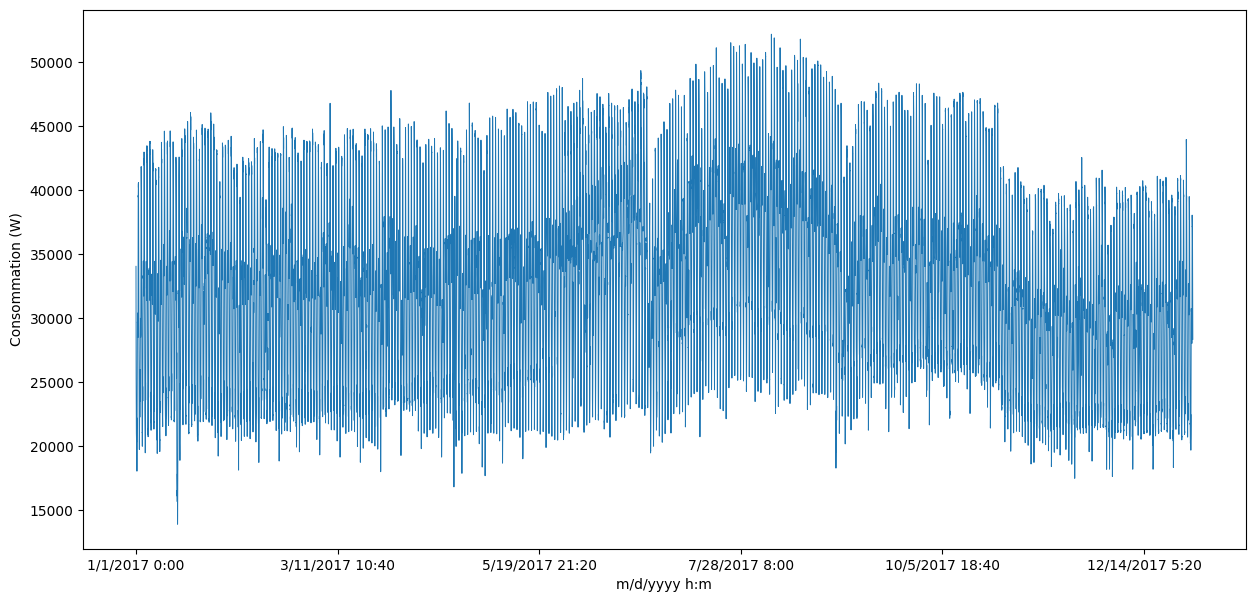

In [3]:
#on commence par lire le fichier de nom "conso.csv" dans le répertoire courant afin de charger les données de la colone "Date"
dataset = pd.read_csv("Tetuan-City-power-consumption.csv", index_col='DateTime')["Zone 1 Power Consumption"]

fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(dataset, lw=0.7)
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("m/d/yyyy h:m")
axes.xaxis.set_major_locator(MaxNLocator(6))

#dataset.plot() #on lance le graphique (affiché grâce à l'interface jupyter)

In [4]:
from scipy import stats

In [5]:
#on vient supprimer les valeurs extrèmes à l'aide de la fonction outlier, utilisant le module stats de scipy
def outlier(df):

    z_score = stats.zscore(df)
    filtered = (np.abs(z_score) < 5)
    new_df = df[filtered]
    
    '''
    cet enchainement de code permet d'attribuer à chaque donnée de consommation un booléen true ou false,
    indiquant true si la valeur est cohérente vis-à-vis de la valeur médiane, et false si elle est incohérente.
    puis, on renvoie dans une nouvelle "dataset" la liste de données lissée.
    '''
    return new_df

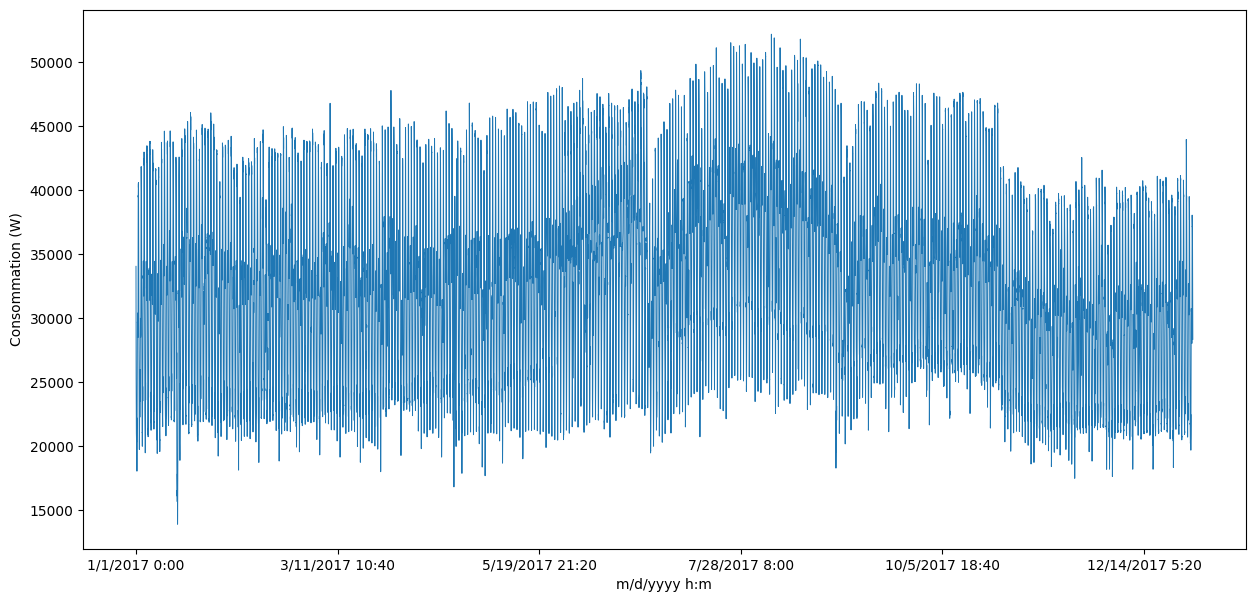

In [6]:
dataset = outlier(dataset)
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(dataset, lw=0.7)
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("m/d/yyyy h:m")
axes.xaxis.set_major_locator(MaxNLocator(6))


In [7]:
_min = dataset.min()
_max = dataset.max()

In [8]:
#mise à l'échelle de la plage de données
def scale(dataset, _min, _max):
    new_dataset = ((dataset - _min) / (_max - _min))
    return new_dataset

def unscale(dataset, _min, _max):
    new_dataset = dataset * (_max - _min) + _min
    return new_dataset

In [9]:
dataset_scaled = scale(dataset, _min, _max)

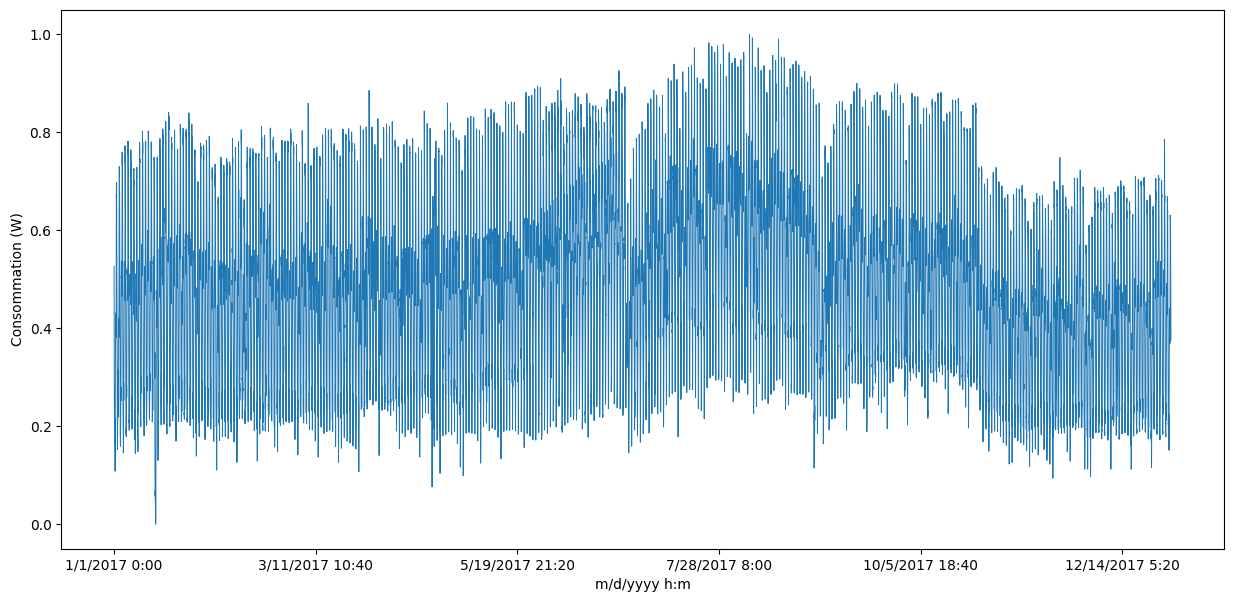

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(dataset_scaled, lw=0.7)
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("m/d/yyyy h:m")
axes.xaxis.set_major_locator(MaxNLocator(6))


In [11]:
size = int(len(dataset) * 0.95)

In [12]:
seq_len = 11

## Prédiction : LSTM

In [13]:
trainGenerator = TimeseriesGenerator(dataset_scaled[:size].to_numpy(), dataset_scaled[:size].to_numpy(), length=seq_len)
testGenerator = TimeseriesGenerator(dataset_scaled[size:].to_numpy(), dataset_scaled[size:].to_numpy(), length=seq_len)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer

In [15]:
def createSimpleLSTM():
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_len, 1)))
    model.add(LSTM(units=100))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model

In [16]:
model = createSimpleLSTM()
model.fit(trainGenerator, epochs=10, batch_size=128)

Epoch 1/10
389/389 [==============================] - 14s 27ms/step - loss: 0.0048
Epoch 2/10
389/389 [==============================] - 11s 29ms/step - loss: 7.5536e-04
Epoch 3/10
389/389 [==============================] - 12s 31ms/step - loss: 5.0522e-04
Epoch 4/10
389/389 [==============================] - 10s 25ms/step - loss: 3.7801e-04
Epoch 5/10
389/389 [==============================] - 10s 25ms/step - loss: 3.0752e-04
Epoch 6/10
389/389 [==============================] - 10s 25ms/step - loss: 2.6742e-04
Epoch 7/10
389/389 [==============================] - 10s 26ms/step - loss: 2.5158e-04
Epoch 8/10
389/389 [==============================] - 10s 24ms/step - loss: 2.3735e-04
Epoch 9/10
389/389 [==============================] - 9s 24ms/step - loss: 2.2809e-04
Epoch 10/10
389/389 [==============================] - 10s 25ms/step - loss: 2.2368e-04


In [17]:
prediction = model.predict(testGenerator)

21/21 [==============================] - 1s 13ms/step


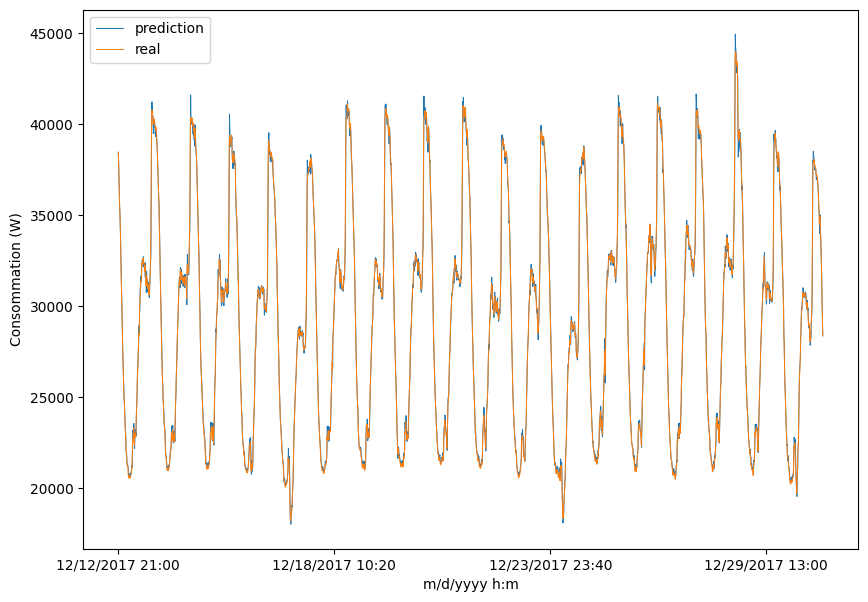

In [18]:
'''
Comme la taille de la séquence est 11, la première valeur prédite par le modèle est la 12-ième, il faut donc enlever les 11 premières valeurs du jeu de test.
Ce phénomène est propre à l'entrainement des modèles de Keras avec un TimeseriesGenerator
'''
#plt.plot(dataset_scaled[size:].to_numpy()[11:], lw=0.7, label='real')
x = dataset_scaled[size+11:].reset_index()["DateTime"]

fig, axes = plt.subplots(1, 1, figsize=(10, 7))
axes.plot(x, unscale(prediction,_min,_max), lw=0.7, label='prediction')
axes.plot(x, unscale(dataset_scaled[size+11:].to_numpy(),_min,_max), lw=0.7, label='real')
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("m/d/yyyy h:m")
axes.xaxis.set_major_locator(MaxNLocator(4))
axes.legend()

In [19]:
np.sqrt(mean_squared_error(prediction, dataset_scaled[size:].to_numpy()[11:]))

0.00893343034794614

## Prédiction : RandomForestRegressor

In [20]:
#définition des dataset utilisés

def create_dataset(dataset, seq_len):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_len-1):
        a = dataset[i:(i + seq_len)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len])
    return np.array(dataX), np.array(dataY)

In [21]:
#to_numpy() permet de convertir une série en array
dataX, dataY = create_dataset(dataset_scaled[:size].to_numpy(), seq_len) 
testX, testY = create_dataset(dataset_scaled[size:].to_numpy(), seq_len)

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
model = RandomForestRegressor(n_estimators=12, max_depth=12)

In [24]:
model.fit(dataX, dataY)

RandomForestRegressor(max_depth=12, n_estimators=12)

In [25]:
prediction = model.predict(testX)

In [26]:
from matplotlib.ticker import MaxNLocator

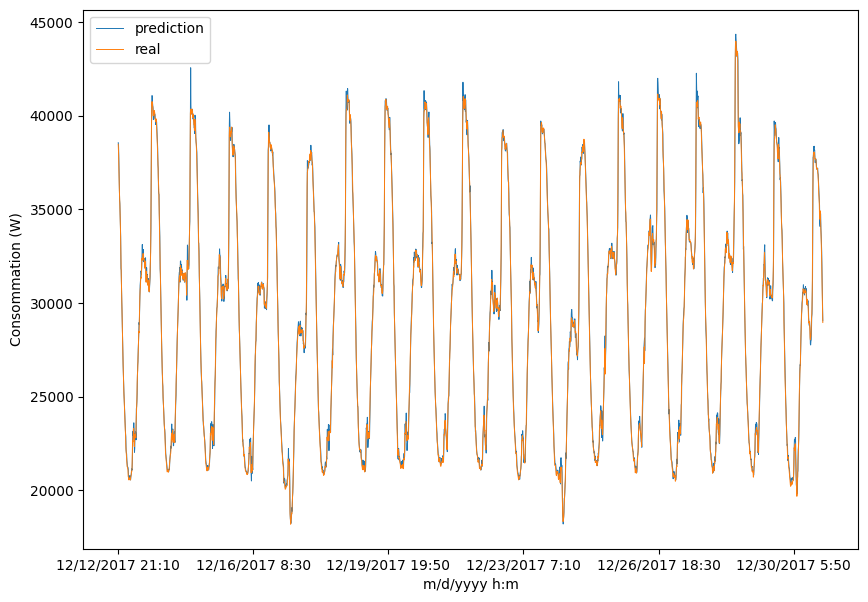

In [27]:
x = dataset_scaled[size+12:].reset_index()["DateTime"]

fig, axes = plt.subplots(1, 1, figsize=(10, 7))
axes.plot(x, unscale(prediction,_min,_max), lw=0.7, label='prediction')
axes.plot(x, unscale(testY,_min,_max), lw=0.7, label='real')
axes.set_ylabel('Consommation (W)')
axes.set_xlabel("m/d/yyyy h:m")
axes.xaxis.set_major_locator(MaxNLocator(6))
axes.legend()

In [28]:
np.sqrt(mean_squared_error(prediction, testY))

0.008366272633308221